In [60]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F

In [61]:
# Set the run id and query id
run_id=181
qid=1281

In [62]:
def get_authors(x):
    p = Doc.objects.get(pk=x)
    das = p.docauthinst_set.order_by(
            'AU','position'
        ).distinct('AU').values_list('id',flat=True)
    authors = p.docauthinst_set.filter(
        id__in=das
    ).order_by('position').values_list('AU',flat=True)
    authors = ", ".join(authors)
    return(authors)

In [63]:
icols = ['doc_id','doc__PY','doc__wosarticle__so','doc__wosarticle__di','doc__title','doc__wosarticle__dt']

dts = DocTopic.objects.filter(run_id=run_id).values(
    'doc_id','doc__PY','doc__wosarticle__so','doc__wosarticle__di','doc__title','doc__wosarticle__dt','topic__title','score'
)
df = pd.DataFrame.from_dict(list(dts))

df_wide = df.pivot_table(index=icols,columns='topic__title',values='score').fillna(0)

df_wide = df_wide.reset_index()

df_wide['authors'] = df_wide.apply(lambda x: get_authors(x['doc_id']),axis=1)

df_wide.to_csv('../data/doc_topics.csv')

In [64]:
print(df_wide.columns.tolist())

['doc_id', 'doc__PY', 'doc__wosarticle__so', 'doc__wosarticle__di', 'doc__title', 'doc__wosarticle__dt', '{activ, school, health}', '{air, pollut, qualiti}', '{bicycl, cycl, cyclist}', '{brt, bus, system}', '{bus, servic, oper}', '{climat, chang, mitig}', '{develop, sustain, plan}', '{emiss, carbon, ghg}', '{energi, build, consumpt}', '{green, build, roof}', '{heat, thermal, comfort}', '{model, network, optim}', '{park, space, price}', '{polici, instrument, effect}', '{price, congest, road}', '{recycl, household, collect}', '{toll, lane, link}', '{transit, rail, station}', '{transport, public, access}', '{travel, mode, choic}', '{treatment, wastewat, plant}', '{urban, land, citi}', '{vehicl, electr, charg}', '{wast, manag, solid}', '{water, heat, suppli}', 'authors']


In [65]:
cols = df_wide.columns.tolist()
cols = [cols[-1]] + cols[1:-1]

df_wide2 = df_wide[cols]
df_wide2.reset_index(drop=True)
df_wide2.to_csv('../data/doc_topics.csv',index=False)

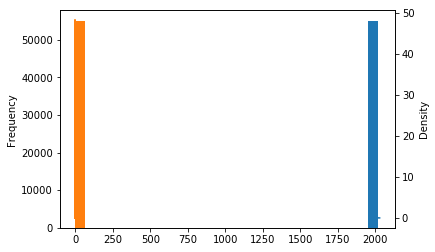

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)

df.plot.hist(ax=ax,bins=30,  legend=False)
ax1 = ax.twinx()
df.plot(kind="kde",ax=ax1, legend=False )
plt.show()

In [ ]:
# Get the papers


In [ ]:
import csv

papers = Doc.objects.filter(query=qid)

with open('../data/doc_topics_compact.csv', 'w', newline='') as csvfile:
    f = csv.writer(csvfile)
    f.writerow(['author','year','source','title','doi','main topics','smaller topics'])

    for p in papers.iterator():
        main_topics = "; ".join([x.topic.title for x in p.doctopic_set.filter(run_id=run_id,score__gt=0.02).order_by('-score')])
        
        small_topics = "; ".join([x.topic.title for x in p.doctopic_set.filter(run_id=run_id,score__gt=0.01,score__lt=0.02).order_by('-score')])
        das = p.docauthinst_set.order_by(
            'AU','position'
        ).distinct('AU').values_list('id',flat=True)
        authors = p.docauthinst_set.filter(
            id__in=das
        ).order_by('position').values_list('AU',flat=True)
        authors = ", ".join(authors)
        f.writerow([authors,str(p.PY),p.wosarticle.so,p.title,p.wosarticle.di,main_topics,small_topics])

In [ ]:
[authors,str(p.PY),p.wosarticle.so,p.title,p.wosarticle.di,main_topics,small_topics]

In [ ]:
p.docauthinst_set.order_by(
            'AU','position'
        ).distinct('AU').values_list('id',flat=True)

In [54]:
docs = Doc.objects.filter(query=qid)
reviews = docs.values('wosarticle__dt').annotate(t=Count('pk'))

In [55]:
reviews = pd.DataFrame.from_dict(list(reviews))
reviews


,t,wosarticle__dt
0,3,Correction
1,7,Meeting Abstract
2,1,Abstract of Published Item
3,509,Article; Proceedings Paper
4,65,Book Review
5,8,Review; Book Chapter
6,63,Editorial Material
7,4,Article; Book Chapter
8,7050,Article
9,1,Software Review


In [53]:
docs.count()

8095

In [57]:
p1 = 1990
p2 = 2016
F = docs.filter(PY=p1).count()
L = docs.filter(PY=p2).count()
N = p2-p1

CAGR = (L/F)**(1/N)-1

In [58]:
CAGR

0.20540589103877305